# Continuous Control Using Reinforcement Learning

## The Cart-Pole System
One tries to balance a pole on top of a cart. This pole is pinned to the cart and can otherwise rotate freely.  Your objective is to prevent the pole from falling down.  The only actions available are to accelerate the cart to the right or left.  We intend to use policy gradients to train a neural network to choose these actions and balance a pole on a cart the available actions are to accelerate the cart to the left or right.  State variables that the agent can observe are the position and the velocity of the cart, and the angular position of the pole and its angular velocity, making this a four dimensional continuous state space.  

## The REINFORCE algorithm 
this <a href="https://people.cs.umass.edu/~barto/courses/cs687/williams92simple.pdf">famous</a> algorithm learns the policy, $\pi(s)$, function, mapping an observable state, $s$, to an action, $a$, without learning the state-action values ($Q$-values) of every concievable state.  In the Markov Decision Process (MDP) framework, an action taken in a state is associated with an immediate reward, $R$, however, what actually matters is the long term accumulated rewards of the system ( $Q(s,a)$ ), which are characterized by the discounted future rewards that are available from a given state, for all future traversible states (see <a href="https://en.wikipedia.org/wiki/Bellman_equation#Example">Bellman Equation</a>).  These are not known a-priori, and as such, the REINFORCE algorithm estimates a gradient (training step) for each action, but waits to apply them to the policy model until future states are evaluated by playing.  Then one computes the relative advantage of each action according to its discounted future rewards, in keeping with the MDP framework, and applies the stored training steps.  

We will try to fit a model for a distribution $\pi(a|s)$ loosely representing the probability that action $a$, is the optimal choice in state $s$.  The advantage of only training the policy function is clear, it is a small model requiring comparatively smaller computer resources, and one does not need to compute or store the values of all concievable states.  Alternative methods to learn $Q$-values could be more expensive (see Deep-$Q$-Networks and Double Deep-$Q$-Networks).  The scheme of storing gradients still preserves the system's orientation toward long-term rewards, thereby mitigating the <a href="https://en.wikipedia.org/wiki/Horizon_effect">Horizon Effect</a>.


In [1]:
import gymnasium as gym
import numpy as np
import tensorflow as tf
import keras
from keras.layers import Input
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import Adam
from matplotlib import pyplot as plt

2025-06-26 21:48:23.790520: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-26 21:48:23.802295: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-26 21:48:23.806269: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-26 21:48:23.814878: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
print(tf.config.list_physical_devices())

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


I0000 00:00:1750988905.654955   67443 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1750988905.684659   67443 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1750988905.684844   67443 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


In [3]:
def draw_state(env, step=0, info=""):
    plt.clf()
    plt.imshow(env.render())
    plt.title("Cart Pole | Step: %d %s" % (step, info))
    plt.axis('off')
    plt.show()

    #display.clear_output(wait=True)
    #display.display(plt.gcf())

observation :  cart position, cart velocity, pole angle, pole angul-veloc.
            :   [-0.0009963  -0.17472702 -0.01570083  0.24166453]
 
plot this thing: 


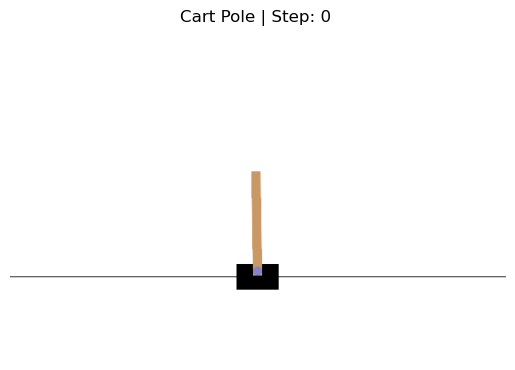

In [4]:
#
# package gymnasium comes with an API to manipulate and 
# observe the 'Cart Pole' system. 
#

env = gym.make('CartPole-v1', render_mode =  "rgb_array")
# get size of state and action from environment
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

env.reset()
obs, reward, done, info, otherstuf = env.step(0)  

# env.step(a) 
# 0: Push cart to the left
# 1: Push cart to the right

print("observation :  cart position, cart velocity, pole angle, pole angul-veloc.")
print("            :  ", obs)
print(' ')
print("plot this thing: ")

plt.figure(1)
draw_state(env)

In [5]:
class CartPoleAgent:
    def __init__(self, env):
        self.state_size = env.observation_space.shape[0]
        self.action_size = env.action_space.n
        
        # Hyperparameters
        self.discount_factor = 0.95
        self.learning_rate   = 0.01

        # data collection schema
        self.n_steps_per_ep = 200
        self.n_eps_per_update = 10
        self.print_every_n = 1
    
        # self.model

    #--------------------------------------------------------------------
    # Methods for model treatment
    #
    def loadModel(self, fname):
        self.model = keras.models.load_model(fname)
        self.model.compile()
        #
    
    def newModel(self):
        self.model = Sequential()
        self.model.add( Input( shape=(self.state_size,) ) )
        self.model.add( Dense( 5, activation='relu' ) )
        self.model.add( Dense( 2, activation='softmax' ) )
        
        #self.model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=self.learning_rate) )
        self.loss_fn = keras.losses.categorical_crossentropy
        self.optimizer = keras.optimizers.Adam(learning_rate = self.learning_rate)

    def saveModel(self, fname):
        self.model.save(fname)

    #--------------------------------------------------------------------
    # Model predicts the next action
    #
    def getActionQuick(self,policy):
        # same as getAction(), but
        # can be used if the policy was already computed
        # in the caller's subroutine
        pol64 = tf.cast(policy, tf.float64)
        m = np.linalg.norm(pol64, ord=1)
        #print(policy, m)
        return np.random.choice( self.action_size, 1, p=(pol64/m) )[0]
        
    def getAction(self, state):
        # provided the current state as input,
        # using the output of policy network, pick action stochastically
        policy = self.model.predict(state, batch_size=1, verbose=0).flatten()
        pol64 = tf.cast(policy, tf.float64)
        m = np.linalg.norm(pol64, ord=1)
        return np.random.choice( self.action_size, 1, p=(pol64/m) )[0]

    def getGreedyAction( self, state ):
        # pick the apparent 'best' action
        policy = self.model.predict(state, batch_size=1, verbose=0).flatten()
        return np.argmax(policy)


    #--------------------------------------------------------------------
    # Methods for training 
    #
    def discountRewards(self, rewards):
        discounted_rewards = np.zeros_like(rewards)
        running_add = 0
        for t in reversed(range(0, len(rewards))):
            running_add = running_add * self.discount_factor + rewards[t]
            discounted_rewards[t] = running_add
        return discounted_rewards

    def discountAndNormalizeRewards( self, all_rewards ):
        all_discounted = [ self.discountRewards(rewards) for rewards in all_rewards ]
        flat_rewards   = np.concatenate(all_discounted)
        reward_mean    = flat_rewards.mean()
        reward_std     = flat_rewards.std()
        return [ (discounted_rew-reward_mean)/reward_std for discounted_rew in all_discounted ]

    def playOneStep(self, state, env):
        with tf.GradientTape() as tape:
            y_out    = self.model(state)
            action   = self.getActionQuick( y_out[0] )
            y_target = tf.one_hot([action], self.action_size)
            loss     = tf.reduce_mean( self.loss_fn( y_target, y_out ) )
        grads = tape.gradient(loss, self.model.trainable_variables)
        next_state, reward, done, info, otherstuf = env.step(action)
        return next_state, reward, done, grads

    def playEpisodes( self, env ):
        all_rewards = []
        all_grads   = []
        avg_score   = 0
        for e in range(self.n_eps_per_update):
            rewards = []
            gradsss = []
            done  = False
            state = env.reset()[0]
            state = np.reshape(state, [1, state_size])
            score = 0
    
            for s in range(self.n_steps_per_ep):
    
                # get action for the current state and go one step in environment
                next_state, reward, done, grads = self.playOneStep(state,env)
                next_state = np.reshape(next_state, [1, state_size])
    
                rewards.append(reward)
                gradsss.append(grads)
    
                state = next_state
                score = score + reward

                if done:
                    break

            all_rewards.append(rewards)
            all_grads.append(gradsss)
            avg_score = avg_score + (1/(e+1))*(score - avg_score)

        return all_rewards, all_grads, avg_score

    def train( self, env, n_iterations ):
        for i in range(n_iterations):
            all_rewards, all_grads, avg_score = self.playEpisodes(env)
            all_discounted_rewards = self.discountAndNormalizeRewards(all_rewards)
            all_mean_grads = []
            for j in range(len(self.model.trainable_variables)):
                #print(all_discounted_rewards[:][:][j])
                #print(all_grads[:][:][j])
                mean_grads = tf.reduce_mean(
                    [  discounted_reward * all_grads[e][s][j] 
                     for e, discounted_rewards in enumerate(all_discounted_rewards)
                     for s, discounted_reward in enumerate(discounted_rewards)
                    ], axis=0)
                all_mean_grads.append(mean_grads)
            self.optimizer.apply_gradients(zip(all_mean_grads, self.model.trainable_variables))

            if ( 0 == (i+1)%self.print_every_n ):
                print("Training iteration:\t ", i+1, '/', n_iterations, ";\t avg. score:\t", avg_score)
            # every episode, plot the play time
            #score = score if score == 500 else score + 100
            #scores.append(score)
            #print("episode:", e, "  score:", score)

            

In [6]:
# 
# Declare an instance of CartPoleAgent
# Lets examine the properties of the policy network
#

agent = CartPoleAgent(env)
agent.newModel()
agent.model.summary()

I0000 00:00:1750988905.859324   67443 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1750988905.859532   67443 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1750988905.859649   67443 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1750988905.914636   67443 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 5)              │            25 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │            12 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37 (148.00 B)

 Trainable params: 37 (148.00 B)

 Non-trainable params: 0 (0.00 B)

In [7]:
#
# Lets examine the model
# and test if each functionality is working as intended
#

state = env.reset()[0]
state = np.reshape(state, [1, state_size])
next_state, reward, done, grads = agent.playOneStep(state,env)

#
# Just checking our model outputs are taking the right shape
#
print(next_state)
print(grads)

[ 0.02724377  0.21611506 -0.0472791  -0.30045912]
[<tf.Tensor: shape=(4, 5), dtype=float32, numpy=
array([[ 0.0000000e+00,  2.8560223e-04, -3.8033072e-03,  2.3388609e-02,
        -0.0000000e+00],
       [ 0.0000000e+00,  2.1652888e-04, -2.8834711e-03,  1.7732037e-02,
        -0.0000000e+00],
       [-0.0000000e+00, -5.0459936e-04,  6.7196479e-03, -4.1322779e-02,
         0.0000000e+00],
       [ 0.0000000e+00,  7.2353847e-05, -9.6352154e-04,  5.9252190e-03,
        -0.0000000e+00]], dtype=float32)>, <tf.Tensor: shape=(5,), dtype=float32, numpy=
array([ 0.        ,  0.01064217, -0.14171964,  0.87151134, -0.        ],
      dtype=float32)>, <tf.Tensor: shape=(5, 2), dtype=float32, numpy=
array([[ 0.        , -0.        ],
       [ 0.01280514, -0.01280514],
       [ 0.01270949, -0.01270949],
       [ 0.01125175, -0.01125175],
       [ 0.        , -0.        ]], dtype=float32)>, <tf.Tensor: shape=(2,), dtype=float32, numpy=array([ 0.5078895, -0.5078895], dtype=float32)>]


In [8]:
#
# This block sets up the model
# edit to chose between loading an old model
# or starting a new model and going through the training process
#

train_new_model = False
model_name = "trainedModel150.keras"

if train_new_model:
    model_name = "newNewModel.keras"
    n_iterations = 150
    agent.print_every_n = 15
    agent.train(env, n_iterations)
    agent.saveModel(model_name)
else:
    agent.loadModel(model_name)


In [9]:
#
# Play the game now with greedy actions
# run and displ
#

obs    = env.reset()
state  = np.reshape(obs[0], [1, agent.state_size])
images = []
N      = 200

for n in range(N):
    img = env.render()
    images.append( img )    
    action = agent.getGreedyAction(state)
    next_state, reward, done, info, otherstf = env.step(action)
    state = np.reshape( next_state, [1, agent.state_size])
    
    if done:
        img = env.render()
        images.append( img )    
        N=n+1
        break


I0000 00:00:1750988906.758176   67505 service.cc:146] XLA service 0x769de40046c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750988906.758195   67505 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce GTX 1060 3GB, Compute Capability 6.1
2025-06-26 21:48:26.761660: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-06-26 21:48:26.770946: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 90101
I0000 00:00:1750988906.844294   67505 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


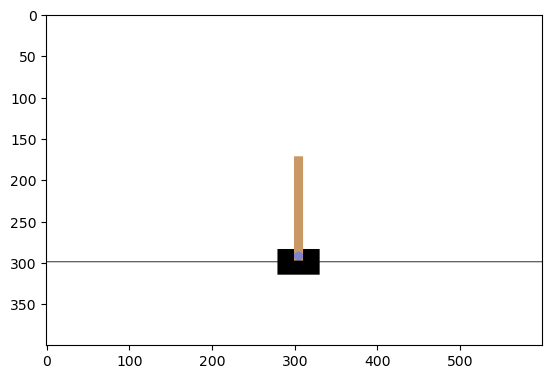

In [10]:
#
# Show animation of the result
#

from IPython.display import HTML
import matplotlib.animation

fig, ax = plt.subplots()

def animate(i):
    ax.imshow(images[i])

ani = matplotlib.animation.FuncAnimation(fig, animate, frames=len(images))

HTML(ani.to_jshtml())

